## MOEA

In [22]:
import warnings; warnings.simplefilter('ignore')

In [24]:
!wget https://raw.githubusercontent.com/cfteach/modules/master/detector2.py 
!pip install pymoo > /dev/null 2>&1
!pip install plotly > /dev/null 2>&1
!pip install ipyvolume > /dev/null 2>&1
!pip install altair > /dev/null 2>&1

--2024-07-10 07:09:27--  https://raw.githubusercontent.com/cfteach/modules/master/detector2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7976 (7.8K) [text/plain]
Saving to: ‘detector2.py.2’

detector2.py.2      100%[===================>]   7.79K  --.-KB/s    in 0.01s   

2024-07-10 07:09:27 (555 KB/s) - ‘detector2.py.2’ saved [7976/7976]



In [3]:
%load_ext autoreload
%autoreload 2


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import AI4NP_detector_opt.sol2.detector2 as detector2
import detector2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Create detector geometry and simulate tracks

The module detector creates a simple 2D geometry of a wire based tracker made by 4 planes.

The adjustable parameters are the radius of each wire, the pitch (along the y axis), and the shift along y and z of a plane with respect to the previous one.

A total of 8 parameters can be tuned.

The goal of this toy model, is to tune the detector design so to optimize the efficiency (fraction of tracks which are detected) as well as the cost for its realization. As a proxy for the cost, we use the material/volume (the surface in 2D) of the detector. For a track to be detetected, in the efficiency definition we require at least two wires hit by the track.

So we want to maximize the efficiency (defined in detector.py) and minimize the cost.

#### LIST OF PARAMETERS
(baseline values)
* R = .5   [cm]
* pitch = 4.0  [cm]
* y1 = 0.0, y2 = 0.0, y3 = 0.0, z1 = 2.0, z2 = 4.0, z3 = 6.0 [cm]


::::: BASELINE PARAMETERS :::::
R, pitch, y1, y2, y3, z1, z2, z3:  0.5 4.0 2.0 1.0 0.0 2.0 4.0 6.0 

:::: INITIAL GEOMETRY ::::
# of wires:  21 , volume:  65.94
:::: TRACK GENERATION ::::


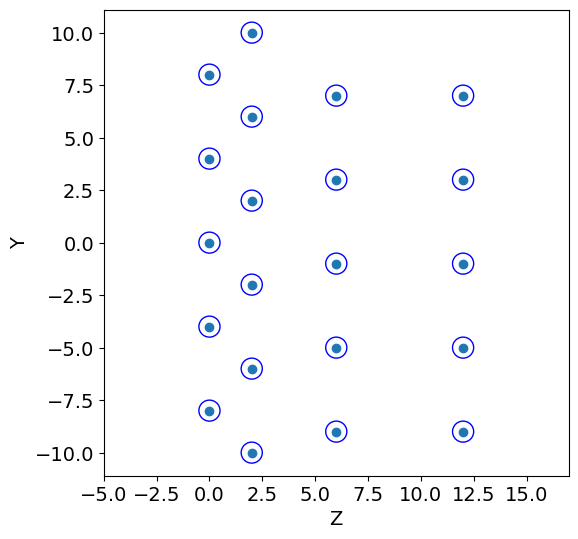

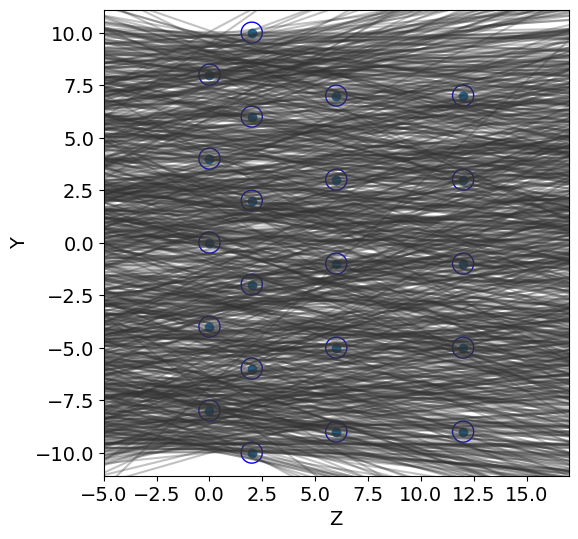

fraction of tracks detected:  0.243
resolution:  0.23594329069824552


In [4]:
# CONSTANT PARAMETERS
#------ define mother region ------#
y_min=-10.1
y_max=10.1
N_tracks = 1000


print("::::: BASELINE PARAMETERS :::::")
R = 0.5
pitch = 4.0
y1 = 2.0
y2 = 1.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

print("R, pitch, y1, y2, y3, z1, z2, z3: ", R, pitch, y1, y2, y3, z1, z2, z3,"\n")


#------------- GEOMETRY ---------------#
print(":::: INITIAL GEOMETRY ::::")
tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)

volume = detector2.wires_volume(Y, y_min, y_max,R)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False,pause=5) #5

print("# of wires: ", num_wires, ", volume: ", volume)

#------------- TRACK GENERATION -----------#
print(":::: TRACK GENERATION ::::")
t = detector2.Tracks(b_min=y_min, b_max=y_max, alpha_mean=0, alpha_std=0.2)
tracks = t.generate(N_tracks)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

 #a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
resolution = score[1]
print("fraction of tracks detected: ",frac_detected)
print("resolution: ",resolution)

---

### Define Objectives



Defines a class for the objectives of the problem that can be used in the MOO.

In [15]:

class objectives():

  def __init__(self,tracks,y_min,y_max):
    self.tracks = tracks
    self.y_min = y_min
    self.y_max = y_max

  def wrapper_geometry(fun):

      def inner(self):
          R, pitch, y1, y2, y3, z1, z2, z3 = self.X
          self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
          return fun(self)
      return inner

  def update_tracks(self, new_tracks):
    self.tracks = new_tracks

  def update_design_point(self,X):
      self.X = X


  def geometry(self,R, pitch, y1, y2, y3, z1, z2, z3):
    tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
    self.R = R
    self.Z, self.Y = tr.create_geometry()


  @wrapper_geometry
  def calc_score(self):
      res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
      assert res[0] >= 0 and res[1] >= 0,"Fraction or Resolution negative."

      return res


  def get_score(self,X):
    R, pitch, y1, y2, y3, z1, z2, z3 = X
    self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
    res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
    return res


  def get_volume(self):
    volume = detector2.wires_volume(self.Y, self.y_min, self.y_max,self.R)
    return volume



res = objectives(tracks,y_min,y_max)

#res.geometry(R, pitch, y1, y2, y3, z1, z2, z3)

X = R, pitch, y1, y2, y3, z1, z2, z3
#fscore  = res.get_score(X)
res.update_design_point(X)
fscore  = res.calc_score()[0]
fvolume = res.get_volume()

print("...check: ", fvolume, fscore)


...check:  65.94 0.243


---
### Multi-Objective Optimization

We will be using pymoo (https://pymoo.org/getting_started.html).

* In the constructor method we specify number of variables N, objectives M, and constraint functions, as well as the lower and upper boundaries of each variable. In our toy model, these boundaries are taken in such a way that all solutions are feasible and no constraint function is needed. You can try to change this and introduce some constraint.



* The *_evaluate* method takes a one-dimensional NumPy array x number of entries equal to n_var. This behavior is enabled by setting *elementwise_evaluation=True* while calling the super() method.

* Notice that every function is minimized. Our efficiency is defined as an tracking inefficiency = 1 - efficiency

* We add the resolution as a third objective.  The average residual of the track hit from the wire centre is used as a proxy for the resolution for this toy-model




In [16]:
from pymoo.core.problem import ElementwiseProblem
class MyProblem(ElementwiseProblem):

    #--------- vectorized ---------#

    def __init__(self):
        super().__init__(n_var=8,
                         n_obj=2,   #<------------
                         n_constr=0,
                         xl=np.array([0.5,2.5,0.,0.,0.,2.,2.,2.]),
                         xu=np.array([1.0,5.0,4.,4.,4.,10.,10.,10.]))

    def _evaluate(self, x, out, *args, **kwargs):


        f1 = 1.-res.get_score(x)[0] # efficiency
        f2 = res.get_volume() # volume
        #f3 = res.get_score(x)[1] #resolution

        out["F"] = [f1, f2]#, f3]




### Creation of Problem and choice of optimization algorithm.


* We will use NSGA-II, as explained in the lectures. You can decide the population size and the number of offsprings, based on what we discussed.


* Pymoo offers different algorithms that can be used which are highly customizable and can be easily extended.
https://pymoo.org/algorithms/index.html


* Before dealing with a problem, it's useful to compare with a list of test problems reported in https://pymoo.org/problems/index.html, where different scenarios in terms of Variables, Objectives, Constraints are described.



In [17]:
problem = MyProblem()


algorithm = NSGA2(pop_size=100,n_offsprings=20) #n_offsprings=10

res = minimize(problem,
               algorithm,
               ("n_gen", 50),
               verbose=True,
               seed=1,
               save_history=True # Saves all of the history of the algorithm
               )

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     16 |             - |             -
     2 |      120 |     16 |  0.0091943315 |             f
     3 |      140 |     18 |  0.0096463023 |         nadir
     4 |      160 |     20 |  0.0852941176 |         ideal
     5 |      180 |     22 |  0.0030228092 |             f
     6 |      200 |     25 |  0.0072161126 |             f
     7 |      220 |     29 |  0.0059171598 |         nadir
     8 |      240 |     31 |  0.0075660660 |             f
     9 |      260 |     38 |  0.0827679783 |         nadir
    10 |      280 |     37 |  0.0014740566 |             f
    11 |      300 |     35 |  0.0048721196 |             f
    12 |      320 |     35 |  0.0037407966 |             f
    13 |      340 |     36 |  0.0008817831 |             f
    14 |      360 |     37 |  0.0055620839 |             f
    15 |      380 |     34 |  0.0040540541 |         ideal
    16 |      400 |     34 |  0.0028855124 |            

In [58]:
#print(res.history[0].pop.get("F"))

[[6.82000000e-01 6.92308623e+01]
 [4.88000000e-01 9.79826469e+01]
 [4.85000000e-01 1.03173827e+02]
 [2.52000000e-01 2.08468853e+02]
 [7.62000000e-01 5.57027201e+01]
 [6.69000000e-01 9.23404015e+01]
 [3.94000000e-01 1.38944056e+02]
 [3.32000000e-01 1.48641574e+02]
 [6.70000000e-01 7.71224967e+01]
 [1.34000000e-01 2.54990517e+02]
 [4.25000000e-01 1.15377738e+02]
 [5.93000000e-01 9.47139898e+01]
 [4.09000000e-01 1.25984876e+02]
 [7.23000000e-01 6.89966728e+01]
 [2.04000000e-01 2.40669046e+02]
 [2.96000000e-01 1.53614529e+02]
 [7.13000000e-01 7.58144876e+01]
 [5.06000000e-01 9.93545304e+01]
 [2.60000000e-01 2.17852241e+02]
 [7.88000000e-01 6.22743828e+01]
 [8.16000000e-01 5.75349925e+01]
 [4.08000000e-01 1.45803479e+02]
 [4.04000000e-01 1.52205754e+02]
 [6.97000000e-01 8.36584980e+01]
 [1.53000000e-01 2.80180540e+02]
 [1.59000000e-01 2.58001358e+02]
 [6.12000000e-01 9.73420648e+01]
 [5.95000000e-01 9.91324585e+01]
 [4.36000000e-01 1.27100205e+02]
 [7.41000000e-01 6.92846028e+01]
 [2.270000

### Analysis of Results


In [21]:
import plotly.express as px

fig = px.scatter(res.F, x=0, y=1, labels={'0': 'Efficiency', '1': 'Volume'},
                    title="Efficiency vs Volume",
                    width=800, height=800)
fig.update_traces(marker=dict(size=8,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
fig.show()

In [59]:
# Making a animation of evolution
import pandas as pd
import plotly.express as px
obj1 = []
obj2 = []
calls = []
for r in res.history:

    objs = r.pop.get("F")
    obj1.extend(objs[:, 0])
    obj2.extend(objs[:, 1])
    calls.extend([r.n_gen]*len(objs))
df = pd.DataFrame(data = {"InEfficiency": obj1, "Volume": obj2, "n_gen": calls})

obj_fig = px.scatter(df, x="InEfficiency", y="Volume",
                        animation_frame="n_gen", color="n_gen",
                        range_x=[0., 0.6], range_y=[0. , 400.],
                        hover_data = df.columns,
                        width = 800, height = 800)
obj_fig.update(layout_coloraxis_showscale=False)
obj_fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 10
obj_fig.update_layout(transition = {'duration': 0.001})
obj_fig.show()

---

### Exercise 


- Can you plot the hypervolume metric to see if the convergence is reached
- Can you implement a termination criterion
- Plot the optimal configuration of the tracker corresponding to that point
- Do analysis of convergence
- Visualize the point with a radar or petal diagram, following https://pymoo.org/visualization/index.html


